In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

np.random.seed(2021)

data_loc = '/Users/simon/Documents/DTU/9. semester/deep learning/data'

df_all = []

files = os.listdir(os.path.join(data_loc,'modified data'))
for file in sorted(files):
    path = os.path.join(data_loc,'modified data',file)
    name, ext = os.path.splitext(file)
    if ext != '.csv':
        continue
    df = pd.read_csv(path)
    df.name = name
    
    for col_name in df.columns:
        if col_name != 'Date_Time':
            df[col_name]=df[col_name].astype('float64')
        else:
            df['Date_Time'] = pd.to_datetime(df['Date_Time'])
    
    df_all.append(df)
    print(name)

case=1

y = torch.Tensor(df_all[case-1]['Park Power [KW]'].values[:,None])
y_time = df_all[case-1]['Date_Time']
x = torch.Tensor(df_all[case+2].iloc[:,1:].values)
x_time = df_all[case+2]['Date_Time']

print(x.shape)
print(y.shape)

del df_all
del df

Measurement 1
Measurement 2
Measurement 3
NWP 1
NWP 2
NWP 3
torch.Size([182918, 25])
torch.Size([147205, 1])


In [2]:
# make sure all time differences are equal
assert x_time.diff().min()==x_time.diff().max()
assert y_time.diff().min()==y_time.diff().max()
assert x_time.diff().min()==y_time.diff().min()
# check that training and target data end at the same time
assert y_time.iloc[-1]==x_time.iloc[-1]

# Time difference between start of training and target data, and corresponding offset in indecies
time_dif = (y_time.iloc[0]-x_time.iloc[0])
idx_offset = time_dif.days*24*4+round(time_dif.seconds/(60*15))

# Index offset between start and end of training data for one single prediction
# i.e. number of quarters of an hour we wish to train on for each sample
idx_train_len = 3*4
subset_to_remove = 0

#i=1000
#print(target_time[i])
#print(x_time[i+idx_offset-idx_train_len+1:i+idx_offset+1])

x_flat = []
x_time_flat = []
y_new = []
y_time_new = []
for i in range(len(y)-subset_to_remove):
    if not (np.isnan(y[i]) or torch.any(torch.isnan(x[i+idx_offset-idx_train_len+1:i+idx_offset+1]))):
        x_flat.append(x[i+idx_offset-idx_train_len+1:i+idx_offset+1].flatten())
        x_time_flat.append(x_time[i+idx_offset-idx_train_len+1:i+idx_offset+1])
        y_new.append(y[i])
        y_time_new.append(y_time[i])

y = torch.stack(y_new)
y_time = y_time_new
x = torch.stack(x_flat)
x_time = x_time_flat

del x_flat
del y_new

In [3]:
print(x.shape)
print(y.shape)
print(len(x_time))
print(len(y_time))
print(x_time[0])
print(y_time[0])

torch.Size([137415, 300])
torch.Size([137415, 1])
137415
137415
35712   2017-01-07 20:00:00
35713   2017-01-07 20:15:00
35714   2017-01-07 20:30:00
35715   2017-01-07 20:45:00
35716   2017-01-07 21:00:00
35717   2017-01-07 21:15:00
35718   2017-01-07 21:30:00
35719   2017-01-07 21:45:00
35720   2017-01-07 22:00:00
35721   2017-01-07 22:15:00
35722   2017-01-07 22:30:00
35723   2017-01-07 22:45:00
Name: Date_Time, dtype: datetime64[ns]
2017-01-07 22:45:00


In [4]:
input_size = x.shape[1]
hidden_size = 50
out_size = 1


# define network
class Net(nn.Module):

    def __init__(self, input_size, hidden_size, out_size):
        super(Net, self).__init__()  
        
        self.model = nn.Sequential(
            nn.Linear(in_features=input_size,
                      out_features=hidden_size,
                      bias=True),
            nn.ReLU(),
            nn.Linear(in_features=hidden_size,
                      out_features=out_size,
                      bias=False)
        )
        
        


    def forward(self, x):
        x = self.model(x)
        return x


net = Net(input_size, hidden_size, out_size)
print(net)

optimizer = optim.Adam(net.parameters())
loss = nn.MSELoss()

Net(
  (model): Sequential(
    (0): Linear(in_features=300, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=1, bias=False)
  )
)


In [9]:
# setting hyperparameters and gettings epoch sizes
batch_size = 10000
num_epochs = 1000

k_fold_size = 5
idx = np.arange(0, y.shape[0])
np.random.shuffle(idx)  # Remove if we implement any sort of recurrent network. If we do a rnn, performance will suffer around the k-fold cv, as the time will be discontinuous
in_val_bool = np.zeros(idx.shape[0], dtype=bool)


def get_fold_idx(k):
    in_val_bool.fill(0)
    in_val_bool[k*y.shape[0]//k_fold_size : (k+1)*y.shape[0]//k_fold_size] = 1
    valid_idx = idx[in_val_bool]
    train_idx = idx[np.logical_not(in_val_bool)]
    return valid_idx, train_idx

get_slice = lambda batch_idx, batch_size: range(batch_idx * batch_size, (batch_idx + 1) * batch_size)

fold=k_fold_size-1
valid_idx, train_idx = get_fold_idx(fold)

num_samples_train = train_idx.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = valid_idx.shape[0]
num_batches_valid = num_samples_valid // batch_size


# setting up lists for handling loss/accuracy
train_loss = []
valid_loss = []
cur_loss = 0

for epoch in range(num_epochs):
    ## Training
    # Forward -> Backprob -> Update params
    net.train()
    cur_loss = 0
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        
        output = net(x[train_idx[slce]])
        
        # compute gradients given loss
        batch_loss = loss(output, y[train_idx][slce])
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    train_loss.append(cur_loss.detach().numpy() / num_batches_train)

    ## Validation
    net.eval()
    cur_loss = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        output = net(x[valid_idx[slce]])
        
        batch_loss = loss(output, y[valid_idx][slce])
        cur_loss += batch_loss   
    valid_loss.append(cur_loss.detach().numpy() / num_batches_valid)
        

    
    if epoch % (num_epochs//10) == 0:
        print("Epoch %2i : Train Loss %f , Valid Loss %f" % (
                epoch, train_loss[-1], valid_loss[-1]))

        

Epoch  0 : Train Loss 0.338741 , Valid Loss 0.333477
Epoch 10 : Train Loss 0.334969 , Valid Loss 0.334794
Epoch 20 : Train Loss 0.332546 , Valid Loss 0.332339
Epoch 30 : Train Loss 0.330785 , Valid Loss 0.330745
Epoch 40 : Train Loss 0.329340 , Valid Loss 0.329441
Epoch 50 : Train Loss 0.328258 , Valid Loss 0.328543
Epoch 60 : Train Loss 0.327297 , Valid Loss 0.327701
Epoch 70 : Train Loss 0.326447 , Valid Loss 0.326891
Epoch 80 : Train Loss 0.325656 , Valid Loss 0.326177
Epoch 90 : Train Loss 0.324916 , Valid Loss 0.325554
Epoch 100 : Train Loss 0.324202 , Valid Loss 0.324952
Epoch 110 : Train Loss 0.323585 , Valid Loss 0.324449
Epoch 120 : Train Loss 0.323021 , Valid Loss 0.324010
Epoch 130 : Train Loss 0.322486 , Valid Loss 0.323646
Epoch 140 : Train Loss 0.321967 , Valid Loss 0.323291
Epoch 150 : Train Loss 0.321569 , Valid Loss 0.322978
Epoch 160 : Train Loss 0.321147 , Valid Loss 0.322610
Epoch 170 : Train Loss 0.320759 , Valid Loss 0.322270
Epoch 180 : Train Loss 0.320376 , Vali

KeyboardInterrupt: 

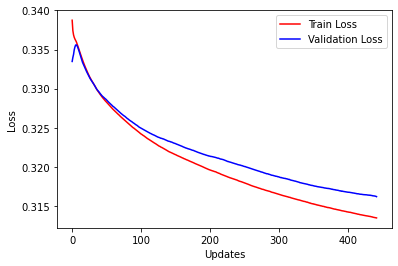

In [10]:
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss, 'r', epoch, valid_loss, 'b')
plt.legend(['Train Loss','Validation Loss'])
plt.xlabel('Updates'), plt.ylabel('Loss')
plt.show()